In [4]:
import requests
import pandas as pd
import json
import numpy as np
import holidays
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
weather_data = pd.read_csv('src/weatherdata2015.csv')

In [6]:
weather_data['Date'] = weather_data['YYYYMMDD'].apply(lambda x: str(x)[0:4] + "-" + str(x)[4:6] + "-" + str(x)[6:8])
weather_data = weather_data.rename(columns = {"T": "Temperature", "R": "Precipitation", "RH": "PrecipitationProbability", "H": "Hour", "FH": "Wind Speed"}) 
weather_data['PrecipitationProbability'] = weather_data['PrecipitationProbability'].replace(-1, 0)
weather_data['Hour'] = weather_data['Hour'].replace(24, 0)
weather_data['Temperature'] = (weather_data['Temperature']*0.1).astype('int')
weather_data = weather_data.sort_values(['Date', 'Hour']).reset_index(drop=True)

In [7]:
weather_data = weather_data[['Date', 'Hour', 'Wind Speed', 'Temperature', 'Precipitation']]

In [8]:
traffic_data = pd.read_csv('src/TrafficCounts2015.csv')

In [9]:
nl_holidays = holidays.CountryHoliday('NL')

In [10]:
full_data = weather_data.merge(traffic_data[['Date', 'Hour', 'Count']], on = ['Date', 'Hour'])
full_data['Date'] = pd.to_datetime(full_data['Date'])
full_data['Month'] = full_data['Date'].apply(lambda x: x.month)
full_data['Day'] = full_data['Date'].apply(lambda x: x.day)
full_data['DayofWeek'] = full_data['Date'].apply(lambda x: x.weekday())
full_data['Precipitation'] = full_data['Precipitation'].astype('bool')
full_data['Count'] = (full_data['Count'] - full_data['Count'].min()) / (full_data['Count'].max() - full_data['Count'].min())
full_data['isHoliday'] = full_data['Date'].apply(lambda x: x in nl_holidays)
full_data = full_data[['Month', 'Day', 'Hour', 'DayofWeek', 'isHoliday','Wind Speed','Temperature', 'Precipitation','Count']]

## Exploratory Data Analysis

In [11]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8596 entries, 0 to 8595
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Month          8596 non-null   int64  
 1   Day            8596 non-null   int64  
 2   Hour           8596 non-null   int64  
 3   DayofWeek      8596 non-null   int64  
 4   isHoliday      8596 non-null   bool   
 5   Wind Speed     8596 non-null   int64  
 6   Temperature    8596 non-null   int32  
 7   Precipitation  8596 non-null   bool   
 8   Count          8596 non-null   float64
dtypes: bool(2), float64(1), int32(1), int64(5)
memory usage: 520.5 KB


In [12]:
numeric_features = list(full_data.select_dtypes("int64", "int32").columns)
categorical_features = list(full_data.select_dtypes("bool").columns)
target = 'Count'

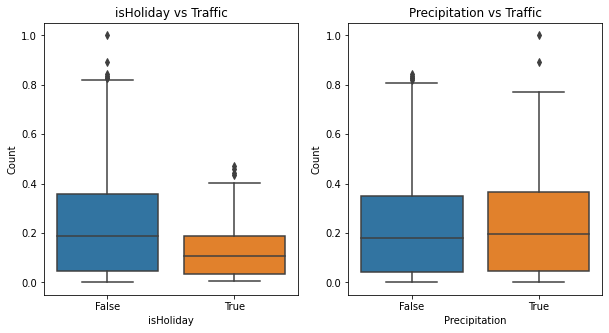

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
for i in range(len(categorical_features)):
    axes[i].set_title(categorical_features[i] + ' vs Traffic')
    sns.boxplot(x= full_data[categorical_features[i]],y=full_data[target], ax = axes[i])

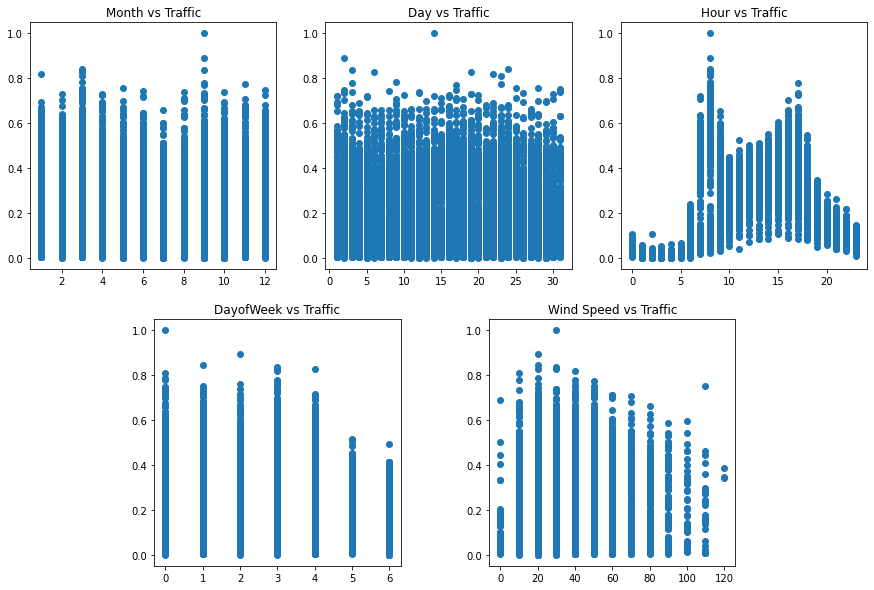

In [14]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])
for i in range(len(numeric_features)):
    axes[int(i/3)][i%3].set_title(numeric_features[i] + ' vs Traffic')
    axes[int(i/3)][i%3].scatter(full_data[numeric_features[i]], full_data[target])

## Model Training

In [15]:
#Train/Test Split (7000 rows for training, rest for testing) - roughly 80-20 split
X_train = full_data.iloc[:7000,:-1]
X_test = full_data.iloc[7000:,:-1]
y_train = full_data.iloc[:7000,-1]
y_test = full_data.iloc[7000:,-1]

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

In [58]:
#RandomForest
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Random Forest")
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("R: {}".format(pearsonr(y_test, y_pred)[0]))

Random Forest
MAE: 0.03849769556786423
R: 0.9283920326570168


In [59]:
import pickle
pickle.dump(model, open("RF_trafficmodel.p", "wb" ))

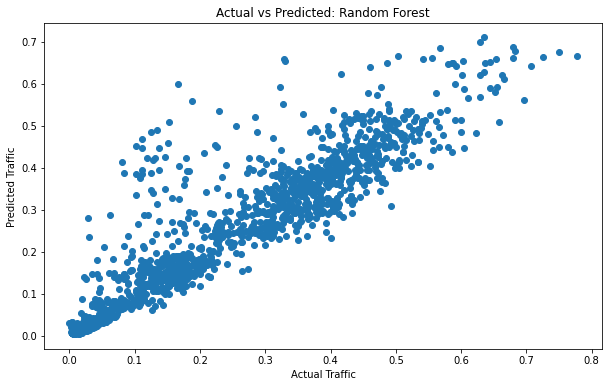

In [18]:
plt.figure(figsize=(10,6))
plt.title('Actual vs Predicted: Random Forest')
plt.xlabel('Actual Traffic')
plt.ylabel('Predicted Traffic')
plt.scatter(y_test, y_pred)

In [19]:
print("Feature Importances: Random Forest")
for i in range(len(X_train.columns)):
    print(X_train.columns[i] + ": " + str(round(model.feature_importances_[i] * 100, 2)) + "%")

Feature Importances: Random Forest
Month: 2.09%
Day: 2.49%
Hour: 78.65%
DayofWeek: 11.23%
isHoliday: 2.11%
Wind Speed: 0.84%
Temperature: 2.37%
Precipitation: 0.22%


In [29]:
#SVM Regression
model = SVR(kernel = 'rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("SVR")
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("R: {}".format(pearsonr(y_test, y_pred)[0]))

SVR
MAE: 0.08407237280269078
R: 0.7820157442700517


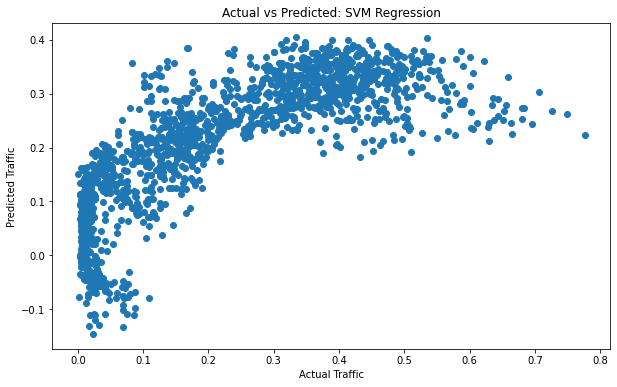

In [30]:
plt.figure(figsize=(10,6))
plt.title('Actual vs Predicted: SVM Regression')
plt.xlabel('Actual Traffic')
plt.ylabel('Predicted Traffic')
plt.scatter(y_test, y_pred)

In [56]:
# Decision Tree Regressor
model = DecisionTreeRegressor(max_depth = 13)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Decision Tree")
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("R: {}".format(pearsonr(y_test, y_pred)[0]))

Decision Tree
MAE: 0.044397589074630046
R: 0.9148131658046146


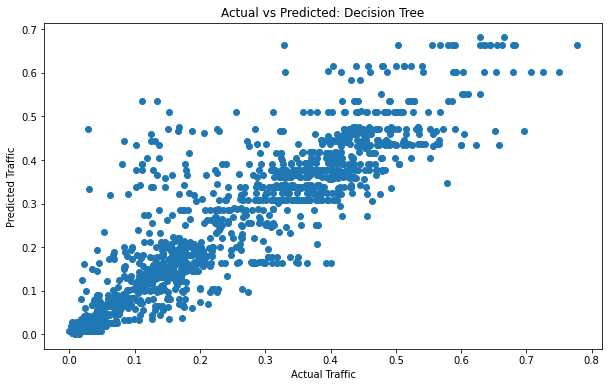

In [57]:
plt.figure(figsize=(10,6))
plt.title('Actual vs Predicted: Decision Tree')
plt.xlabel('Actual Traffic')
plt.ylabel('Predicted Traffic')
plt.scatter(y_test, y_pred)